In [69]:
# Import necessary libraries
import cv2
import pytesseract
import numpy as np
import arabic_reshaper
from bidi.algorithm import get_display
from PIL import Image
import matplotlib.pyplot as plt

In [70]:
# Utility function to create enumerations
def enum(*sequential, **named):
    enums = dict(zip(sequential, range(len(sequential))), **named)
    return type('Enum', (), enums)


In [71]:
# Define OCR_MODES enumeration
OCR_MODES = enum('TRAINED', 'TESSERACT')

In [72]:
# Define PlateDetector class
class PlateDetector:
    def load_model(self, weight_path: str, cfg_path: str):
        self.net = cv2.dnn.readNetFromDarknet(cfg_path, weight_path)
        with open("./license_plate_detection/MLPDR/classes-detection.names", "r") as f:
            self.classes = [line.strip() for line in f.readlines()]
        self.layers_names = self.net.getLayerNames()
        unconnected_out_layers = self.net.getUnconnectedOutLayers().flatten()

        print("Unconnected Out Layers (indices):", unconnected_out_layers)  # Debug print

        self.output_layers = [self.layers_names[i - 1] for i in unconnected_out_layers]
        print("Layer Names:", self.layers_names)
        print("Output Layers:", self.output_layers)


    def load_image(self, img_path):
        img = cv2.imread(img_path)
        height, width, channels = img.shape
        return img, height, width, channels

    def detect_plates(self, img):
        blob = cv2.dnn.blobFromImage(img, scalefactor=0.00392, size=(320, 320), mean=(0, 0, 0), swapRB=True, crop=False)
        self.net.setInput(blob)
        outputs = self.net.forward(self.output_layers)
        return blob, outputs

    def get_boxes(self, outputs, width, height, threshold=0.3):
        boxes = []
        confidences = []
        class_ids = []
        for output in outputs:
            for detection in output:
                scores = detection[5:]
                class_id = np.argmax(scores)
                confidence = scores[class_id]
                if confidence > threshold:
                    center_x = int(detection[0] * width)
                    center_y = int(detection[1] * height)
                    w = int(detection[2] * width)
                    h = int(detection[3] * height)
                    x = int(center_x - w / 2)
                    y = int(center_y - h / 2)
                    boxes.append([x, y, w, h])
                    confidences.append(float(confidence))
                    class_ids.append(class_id)
        return boxes, confidences, class_ids

    def draw_labels(self, boxes, confidences, class_ids, img):
        indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.1, 0.1)
        font = cv2.FONT_HERSHEY_PLAIN
        plats = []
        for i in range(len(boxes)):
            if i in indexes:
                x, y, w, h = boxes[i]
                label = str(self.classes[class_ids[i]])
                color_green = (0, 255, 0)
                crop_img = img[y:y + h, x:x + w]
                try:
                    crop_resized = cv2.resize(crop_img, dsize=(470, 110))
                    plats.append(crop_resized)
                    cv2.rectangle(img, (x, y), (x + w, y + h), color_green, 8)
                    confidence = round(confidences[i], 3) * 100
                    # Adjust font scale and thickness
                    cv2.putText(img, str(confidence) + "%", (x + 20, y - 20), font, 2, (0, 255, 0), 2)
                except cv2.error as err:
                    print(err)

        return img, plats


In [73]:
# Define PlateReader class
class PlateReader:
    def load_model(self, weight_path: str, cfg_path: str):
        self.net = cv2.dnn.readNetFromDarknet(cfg_path, weight_path)
        with open("./license_plate_detection/MLPDR/classes-ocr.names", "r") as f:
            self.classes = [line.strip() for line in f.readlines()]
        self.layers_names = self.net.getLayerNames()
        unconnected_out_layers = self.net.getUnconnectedOutLayers().flatten()

        print("Unconnected Out Layers (indices):", unconnected_out_layers)  # Debug print

        self.output_layers = [self.layers_names[i - 1] for i in unconnected_out_layers]
        print("Layer Names:", self.layers_names)
        print("Output Layers:", self.output_layers)

        self.colors = np.random.uniform(0, 255, size=(len(self.classes), 3))
    def load_image(self, img_path):
        img = cv2.imread(img_path)
        height, width, channels = img.shape
        return img, height, width, channels

    def read_plate(self, img):
        blob = cv2.dnn.blobFromImage(img, scalefactor=0.00392, size=(320, 320), mean=(0, 0, 0), swapRB=True, crop=False)
        self.net.setInput(blob)
        outputs = self.net.forward(self.output_layers)
        return blob, outputs

    def get_boxes(self, outputs, width, height, threshold=0.3):
        boxes = []
        confidences = []
        class_ids = []
        for output in outputs:
            for detect in output:
                scores = detect[5:]
                class_id = np.argmax(scores)
                confidence = scores[class_id]
                if confidence > threshold:
                    center_x = int(detect[0] * width)
                    center_y = int(detect[1] * height)
                    w = int(detect[2] * width)
                    h = int(detect[3] * height)
                    x = int(center_x - w / 2)
                    y = int(center_y - h / 2)
                    boxes.append([x, y, w, h])
                    confidences.append(float(confidence))
                    class_ids.append(class_id)
        return boxes, confidences, class_ids

    def draw_labels(self, boxes, confidences, class_ids, img):
        indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.1, 0.1)
        font = cv2.FONT_HERSHEY_PLAIN
        c = 0
        characters = []
        for i in range(len(boxes)):
            if i in indexes:
                x, y, w, h = boxes[i]
                label = str(self.classes[class_ids[i]])
                color = self.colors[i % len(self.colors)]
                cv2.rectangle(img, (x, y), (x + w, y + h), color, 3)
                confidence = round(confidences[i], 3) * 100
                cv2.putText(img, str(confidence) + "%", (x, y - 6), font, 1, color, 2)
                characters.append((label, x))
        characters.sort(key=lambda x: x[1])
        plate = ""
        for l in characters:
            plate += l[0]
        chg = 0
        for i in range(len(plate)):
            if plate[i] in ['b', 'h', 'd', 'a']:
                if plate[i - 1] == 'w':
                    ar = i - 1
                    chg = 2
                elif plate[i - 1] == 'c':
                    ar = i - 1
                    chg = 3
                else:
                    ar = i
                    chg = 1

        if chg == 1:
            plate = plate[:ar] + ' | ' + str(self.arabic_chars(ord(plate[ar])), encoding="utf-8") + ' | ' + plate[ar + 1:]
        if chg == 2:
            # Convert character to integer by summing ASCII values if needed
            index = sum(ord(plate[ar + j]) for j in range(3))
            plate = plate[:ar] + ' | ' + str(self.arabic_chars(index), encoding="utf-8") + ' | ' + plate[ar + 3:]
        if chg == 3:
            index = sum(ord(plate[ar + j]) for j in range(2))
            plate = plate[:ar] + ' | ' + str(self.arabic_chars(index), encoding="utf-8") + ' | ' + plate[ar + 2:]

        return img, plate

    def arabic_chars(self, index):
        if index == ord('a'):
            return "أ".encode("utf-8")

        if index == ord('b'):
            return "ب".encode("utf-8")

        if index == 2 * ord('w') + ord('a') or index == ord('w'):
            return "و".encode("utf-8")

        if index == ord('d'):
            return "د".encode("utf-8")

        if index == ord('h'):
            return "ه".encode("utf-8")

        if index == ord('c') + ord('h'):
            return "ش".encode("utf-8")

    def tesseract_ocr(self, image_path, lang="eng", psm=7):
        alphanumeric = "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
        options = f"-l {lang} --psm {psm} -c tessedit_char_whitelist={alphanumeric}"
        return pytesseract.image_to_string(image_path, config=options)

    

In [74]:
# Load models
detector = PlateDetector()
detector.load_model('./license_plate_detection/MLPDR/weights/detection/yolov3-detection_final.weights', './license_plate_detection/MLPDR/weights/detection/yolov3-detection.cfg')

reader = PlateReader()
reader.load_model('./license_plate_detection/MLPDR/weights/ocr/yolov3-ocr_final.weights', './license_plate_detection/MLPDR/weights/ocr/yolov3-ocr.cfg')


Unconnected Out Layers (indices): [200 227 254]
Layer Names: ('conv_0', 'bn_0', 'leaky_1', 'conv_1', 'bn_1', 'leaky_2', 'conv_2', 'bn_2', 'leaky_3', 'conv_3', 'bn_3', 'leaky_4', 'shortcut_4', 'conv_5', 'bn_5', 'leaky_6', 'conv_6', 'bn_6', 'leaky_7', 'conv_7', 'bn_7', 'leaky_8', 'shortcut_8', 'conv_9', 'bn_9', 'leaky_10', 'conv_10', 'bn_10', 'leaky_11', 'shortcut_11', 'conv_12', 'bn_12', 'leaky_13', 'conv_13', 'bn_13', 'leaky_14', 'conv_14', 'bn_14', 'leaky_15', 'shortcut_15', 'conv_16', 'bn_16', 'leaky_17', 'conv_17', 'bn_17', 'leaky_18', 'shortcut_18', 'conv_19', 'bn_19', 'leaky_20', 'conv_20', 'bn_20', 'leaky_21', 'shortcut_21', 'conv_22', 'bn_22', 'leaky_23', 'conv_23', 'bn_23', 'leaky_24', 'shortcut_24', 'conv_25', 'bn_25', 'leaky_26', 'conv_26', 'bn_26', 'leaky_27', 'shortcut_27', 'conv_28', 'bn_28', 'leaky_29', 'conv_29', 'bn_29', 'leaky_30', 'shortcut_30', 'conv_31', 'bn_31', 'leaky_32', 'conv_32', 'bn_32', 'leaky_33', 'shortcut_33', 'conv_34', 'bn_34', 'leaky_35', 'conv_35', 'b

In [75]:
# Function to process an image
def process_image(image_path, ocr_mode=OCR_MODES.TRAINED):
    image, height, width, channels = detector.load_image(image_path)
    blob, outputs = detector.detect_plates(image)
    boxes, confidences, class_ids = detector.get_boxes(outputs, width, height, threshold=0.3)
    plate_img, LpImg = detector.draw_labels(boxes, confidences, class_ids, image)

    if len(LpImg):
        cv2.imwrite("./license_plate_detection/MLPDR/tmp/car_box.jpg", plate_img)
        cv2.imwrite('./license_plate_detection/MLPDR/tmp/plate_box.jpg', LpImg[0])
        display_image('./license_plate_detection/MLPDR/tmp/car_box.jpg', 'Detected Plates')
        display_image('./license_plate_detection/MLPDR/tmp/plate_box.jpg', 'Detected Plate')

        if ocr_mode == OCR_MODES.TRAINED:
            return apply_trained_ocr('./license_plate_detection/MLPDR/tmp/plate_box.jpg')
        elif ocr_mode == OCR_MODES.TESSERACT:
            return reader.tesseract_ocr('./license_plate_detection/MLPDR/tmp/plate_box.jpg')
    else:
        print("No license plate detected.")
        return None


In [76]:
# Function to apply trained OCR
def apply_trained_ocr(plate_path):
    image, height, width, channels = reader.load_image(plate_path)
    blob, outputs = reader.read_plate(image)
    boxes, confidences, class_ids = reader.get_boxes(outputs, width, height, threshold=0.3)
    segmented, plate_text = reader.draw_labels(boxes, confidences, class_ids, image)
    cv2.imwrite("./license_plate_detection/MLPDR/tmp/plate_segmented.jpg", segmented)
    display_image("./license_plate_detection/MLPDR/tmp/plate_segmented.jpg", 'Segmented Plate')
    return arabic_reshaper.reshape(plate_text)

Enter the path of the image: ./license_plate_detection/MLPDR/test_images/porshe.png
Enter OCR mode (trained/tesseract): trained


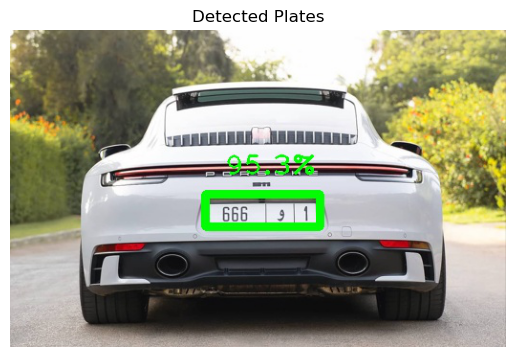

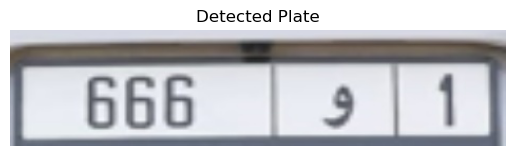

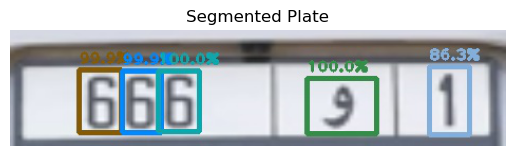

Detected Plate Text: 666 | ﻭ | 1


In [79]:
# Example usage
image_path = input("Enter the path of the image: ")
# Trained mode for morrocan plates and tesseract for general plates
ocr_mode = input("Enter OCR mode (trained/tesseract): ").strip().lower()

if ocr_mode == "trained":
    ocr_mode = OCR_MODES.TRAINED
else:
    ocr_mode = OCR_MODES.TESSERACT

result = process_image(image_path, ocr_mode)
print("Detected Plate Text:", result)